# Shor's algorithm

One should start from here when exploring quantum options for number factoring.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute, transpile, assemble
from qiskit.quantum_info.operators import Operator
from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_histogram
import math
from numpy.random import randint
import pandas as pd
from fractions import Fraction

We would need to find the unitary so that $U|y\rangle = |a^r mod\quad N\rangle$ for our desired $N$. In our case $N=21$. $a$ can be randomly chosen but we will need to ensure it is not a non-trivial factor of our desired $N$.

In [2]:
# Base parameters
a = 2
N = 15

# Bits required to represent the number
eig_qubits = math.ceil(math.log(N,2))
length = 2**eig_qubits
control_qubits = 6

In [3]:
U_matrix = np.zeros((length,length), dtype=complex)
for i in range(N):
    ind = int((a*i)%N)
    print("U|{}> = |{}>".format(i, ind))
    U_matrix[i,ind] = 1 + 0.j
    
for i in range(N, length):
    print("U|{}> = |{}>".format(i, i))
    U_matrix[i,i] = 1 + 0.j

U|0> = |0>
U|1> = |2>
U|2> = |4>
U|3> = |6>
U|4> = |8>
U|5> = |10>
U|6> = |12>
U|7> = |14>
U|8> = |1>
U|9> = |3>
U|10> = |5>
U|11> = |7>
U|12> = |9>
U|13> = |11>
U|14> = |13>
U|15> = |15>


In [4]:
       
array_to_latex(U_matrix, pretext="\\text{U} = ")


<IPython.core.display.Math object>

In [9]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(eig_qubits)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    return U

circ = c_amod15(a,1)
circ.save_unitary(label='unitary', pershot=False)

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get unitary
result = simulator.run(circ).result()
unitary = result.get_unitary(circ)
array_to_latex(unitary.round(5), pretext="\\text{Circuit unitary} = ")

<IPython.core.display.Math object>

In [10]:
np.array_equal(U_matrix,unitary)

True

In [11]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [12]:
# Create operator   
U = Operator(U_matrix)
# Add to a circuit
def c_amodN(exponent, eig_qubits):
    """Controlled multiplication by a mod N"""
    circ = QuantumCircuit(eig_qubits)
    for i in range(exponent):
        circ.append(U, [i for i in range(eig_qubits)])
    exp_U_gate = circ.to_gate(label='{}^{} mod {}'.format(a,exponent, N)).control()
    return exp_U_gate

In [13]:
def qft_dagger_gate(n):
    circ = QuantumCircuit(n)
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
        
    for j in range(n):
        for m in range(j):
            circ.cp(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)
    qft_gate = circ.to_gate(label='QFT+')
    return qft_gate

In [14]:
# PERIOD FINDING CIRCUIT
qpe_p = QuantumCircuit(control_qubits+eig_qubits, control_qubits)

for i in range(control_qubits):
    qpe_p.h(i)

qpe_p.x(control_qubits+eig_qubits-1)
qpe_p.barrier()

# Do controlled-U operations

for q in range(control_qubits):
    qpe_p.append(c_amod15(a, 2**q), 
             [q] + [i+control_qubits for i in range(eig_qubits)])
    
#for q in range(control_qubits):
#    qpe_p.append(c_amodN(2**q, eig_qubits), [q] + [i+control_qubits for i in range(eig_qubits)])
    
qpe_p.barrier()
qft_d_gate = qft_dagger_gate(control_qubits)
qpe_p.append(qft_d_gate, [i for i in range(control_qubits)])
qpe_p.barrier()

for i in range(control_qubits):
    qpe_p.measure(i, i)

In [15]:
qpe_p.draw(fold=-1)

┌───┐ ░                                                                                              ░ ┌───────┐ ░ ┌─┐               
q_0: ┤ H ├─░────────■─────────────────────────────────────────────────────────────────────────────────────░─┤0      ├─░─┤M├───────────────
     ├───┤ ░        │                                                                                     ░ │       │ ░ └╥┘┌─┐            
q_1: ┤ H ├─░────────┼──────────────■──────────────────────────────────────────────────────────────────────░─┤1      ├─░──╫─┤M├────────────
     ├───┤ ░        │              │                                                                      ░ │       │ ░  ║ └╥┘┌─┐         
q_2: ┤ H ├─░────────┼──────────────┼──────────────■───────────────────────────────────────────────────────░─┤2      ├─░──╫──╫─┤M├─────────
     ├───┤ ░        │              │              │                                                       ░ │  QFT+ │ ░  ║  ║ └╥┘┌─┐      
q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────░─┤3      ├─░──╫──╫──╫─┤M├──────
     ├───┤ ░        │              │              │              │                                        ░ │       │ ░  ║  ║  ║ └╥┘┌─┐   
q_4: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────░─┤4      ├─░──╫──╫──╫──╫─┤M├───
     ├───┤ ░        │              │              │              │              │                         ░ │       │ ░  ║  ║  ║  ║ └╥┘┌─┐
q_5: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────░─┤5      ├─░──╫──╫──╫──╫──╫─┤M├
     └───┘ ░ ┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐ ░ └───────┘ ░  ║  ║  ║  ║  ║ └╥┘
q_6: ──────░─┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├─░───────────░──╫──╫──╫──╫──╫──╫─
           ░ │             ││             ││             ││             ││              ││              │ ░           ░  ║  ║  ║  ║  ║  ║ 
q_7: ──────░─┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├─░───────────░──╫──╫──╫──╫──╫──╫─
           ░ │  2^1 mod 15 ││  2^2 mod 15 ││  2^4 mod 15 ││  2^8 mod 15 ││  2^16 mod 15 ││  2^32 mod 15 │ ░           ░  ║  ║  ║  ║  ║  ║ 
q_8: ──────░─┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├─░───────────░──╫──╫──╫──╫──╫──╫─
     ┌───┐ ░ │             ││             ││             ││             ││              ││              │ ░           ░  ║  ║  ║  ║  ║  ║ 
q_9: ┤ X ├─░─┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3             ├─░───────────░──╫──╫──╫──╫──╫──╫─
     └───┘ ░ └─────────────┘└─────────────┘└─────────────┘└─────────────┘└──────────────┘└──────────────┘ ░           ░  ║  ║  ║  ║  ║  ║ 
c: 6/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╩══╩═
                                                                                                                         0  1  2  3  4  5

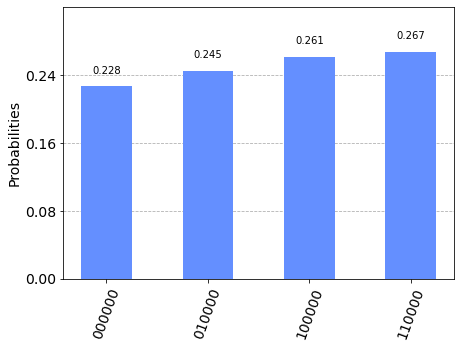

In [16]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qpe_p, backend=backend).result()
answer = results.get_counts()

plot_histogram(answer)

In [17]:
answer

{'110000': 273, '000000': 233, '100000': 267, '010000': 251}

In [18]:
rows, measured_phases = [], []
for output in answer:
    if answer[output] > 20:
        decimal = int(output, 2)
        phase = decimal/(2**control_qubits)
        measured_phases.append(phase)
        # Add these values to the rows in our table:
        rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                     f"{decimal}/{2**control_qubits} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

          Register Output         Phase
0  110000(bin) =  48(dec)  48/64 = 0.75
1  000000(bin) =   0(dec)   0/64 = 0.00
2  100000(bin) =  32(dec)  32/64 = 0.50
3  010000(bin) =  16(dec)  16/64 = 0.25


In [19]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.00      0/1            1
2   0.50      1/2            2
3   0.25      1/4            4


In [20]:
r = 4
# Compute the non-trivial factor.
y = a**(r // 2) % N
assert 1 < y < N
q = math.gcd(y - 1, N)
p = math.gcd(y + 1, N)
if 1 < q < N and 1 < p < N :
    print(f'{p}*{q}={N}')

5*3=15
